In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

path_video_out = '/media/kimbring2/Steam/sim2real/raw_video.avi'
video_out = cv2.VideoWriter(path_video_out, cv2.VideoWriter_fourcc(*'DIVX'), 20, (640,360))

imported_seg = tf.saved_model.load("/media/kimbring2/Steam/sim2real/segmentation_model")
imported_gan = tf.saved_model.load("/media/kimbring2/Steam/sim2real/cyclegan_model")

f_seg = imported_seg.signatures["serving_default"]
f_gan = imported_gan.signatures["serving_default"]

In [2]:
seg_test_input = np.zeros([1,256,256,3])
gan_test_input = np.zeros([1,256,256,3])
#style_test_input = np.zeros([1,256,256,3])

seg_test_tensor = tf.convert_to_tensor(seg_test_input, dtype=tf.float32)
gan_test_tensor = tf.convert_to_tensor(gan_test_input, dtype=tf.float32)

seg_test_result = f_seg(seg_test_tensor)['conv2d_transpose_4'].numpy()[0]
gan_test_result = f_gan(gan_test_tensor)['conv2d_transpose_7'].numpy()[0]

print("seg_test_result.shape: " + str(seg_test_result.shape))
print("gan_test_result.shape: " + str(gan_test_result.shape))

seg_test_result.shape: (256, 256, 3)
gan_test_result.shape: (256, 256, 3)


True

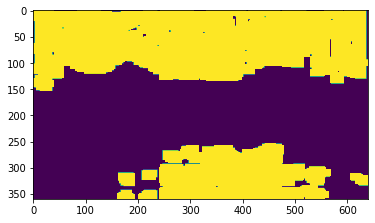

In [3]:
import matplotlib.pyplot as plt

image_path = '/media/kimbring2/Steam/sim2real/content_image.jpg'
test_image = cv2.imread(image_path)
frame = test_image
test_image = cv2.normalize(test_image, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)

test_tensor = tf.convert_to_tensor(test_image, dtype=tf.float32)
test_tensor = tf.image.resize(test_tensor, [256,256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
test_tensor = tf.reshape(test_tensor, [1,256,256,3], name=None)

#pred_masks = model.predict(test_tensor)
pred_mask = f_seg(test_tensor)['conv2d_transpose_4']
pred_mask = tf.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[..., tf.newaxis]
pred_mask = pred_mask[0]
pred_mask = tf.keras.preprocessing.image.array_to_img(pred_mask)
pred_mask = np.array(pred_mask)
ret, thresh = cv2.threshold(pred_mask, 126, 255, cv2.THRESH_BINARY)

kernel = np.ones((5, 5), np.uint8)
erudition_image = cv2.erode(thresh, kernel, iterations=2)  #// make dilation image
dilation_image = cv2.dilate(erudition_image, kernel, iterations=2)  #// make dilation image
dilation_image = cv2.resize(np.float32(dilation_image), dsize=(640,360), interpolation=cv2.INTER_AREA)
plt.imshow(dilation_image)
dilation_image = dilation_image != 255.0

# converting from BGR to HSV color space
hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

# Red color
low_red = np.array([120, 155, 84])
high_red = np.array([179, 255, 255])
red_mask = cv2.inRange(hsv_frame, low_red, high_red)
red = cv2.bitwise_and(frame, frame, mask=red_mask)

# Blue color
low_blue = np.array([110, 130, 2])
high_blue = np.array([126, 255, 255])
blue_mask = cv2.inRange(hsv_frame, low_blue, high_blue)
kernel = np.ones((10, 10), np.uint8)
blue_mask = cv2.dilate(blue_mask, kernel, iterations=1)  #// make dilation image
blue = cv2.bitwise_and(frame, frame, mask=blue_mask)

# Green color
low_green = np.array([25, 52, 72])
high_green = np.array([60, 255, 255])
green_mask = cv2.inRange(hsv_frame, low_green, high_green)
kernel = np.ones((5, 5), np.uint8)
green_mask = cv2.dilate(green_mask, kernel, iterations=1)  #// make dilation image
green = cv2.bitwise_and(frame, frame, mask=green_mask)

mask = green_mask + blue_mask + dilation_image

result = cv2.bitwise_and(frame, frame, mask=mask)
result_mean = np.mean(result)

for i in range(0, result.shape[0]):
    for j in range(0, result.shape[1]):
        if result[i,j,0] == 0 and result[i,j,1] == 0 and result[i,j,2] == 0:
            result[i][j] = result_mean     
            
cv2.imwrite("/media/kimbring2/Steam/sim2real/image_seg.jpg", result)
            
test_image = result
test_image = (test_image / 127.5) - 1

test_tensor = tf.convert_to_tensor(test_image, dtype=tf.float32)
test_tensor = tf.image.resize(test_tensor, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
test_tensor = tf.reshape(test_tensor, [1,256,256,3], name=None)

#generate_images(f_gan, test_tensor)
prediction = f_gan(test_tensor)['conv2d_transpose_7'].numpy()

gan_result = prediction[0]* 0.5 + 0.5
gan_result = gan_result * 255

#plt.imshow(gan_result)
cv2.imwrite("/media/kimbring2/Steam/sim2real/image_gan.jpg", gan_result)

In [42]:
path_dilation_video = '/home/kimbring2/Desktop/dilation_video.avi'
path_segmented_video = '/home/kimbring2/Desktop/segmented_video.avi'

dilation_video_out = cv2.VideoWriter(path_dilation_video, cv2.VideoWriter_fourcc(*'DIVX'), 5, (640,360))
segmented_video_out = cv2.VideoWriter(path_segmented_video, cv2.VideoWriter_fourcc(*'DIVX'), 5, (640,360))

cap = cv2.VideoCapture('/home/kimbring2/Desktop/image_real_3.avi')

frame_index = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    print("ret: " + str(ret))
    if ret == True:
        frame_index += 1
        
        test_image = cv2.normalize(test_image, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
        
        test_tensor = tf.convert_to_tensor(test_image, dtype=tf.float32)
        test_tensor = tf.image.resize(test_tensor, [256,256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        test_tensor = tf.reshape(test_tensor, [1,256,256,3], name=None)

        #pred_masks = model.predict(test_tensor)
        pred_mask = f_seg(test_tensor)['conv2d_transpose_4']
        pred_mask = tf.argmax(pred_mask, axis=-1)
        pred_mask = pred_mask[..., tf.newaxis]
        pred_mask = pred_mask[0]
        pred_mask = tf.keras.preprocessing.image.array_to_img(pred_mask)
        pred_mask = np.array(pred_mask)
        ret, thresh = cv2.threshold(pred_mask, 126, 255, cv2.THRESH_BINARY)

        kernel = np.ones((5, 5), np.uint8)
        erudition_image = cv2.erode(thresh, kernel, iterations=2)  #// make dilation image
        dilation_image = cv2.dilate(erudition_image, kernel, iterations=2)  #// make dilation image
        dilation_image = cv2.resize(np.float32(dilation_image), dsize=(640,360), interpolation=cv2.INTER_AREA)
        dilation_image_rgb = cv2.cvtColor(dilation_image, cv2.COLOR_GRAY2RGB)
        #print("np.uint8(dilation_image_rgb).shape: " + str(np.uint8(dilation_image_rgb).shape))
        dilation_video_out.write(np.uint8(dilation_image_rgb))
        
        dilation_image = dilation_image != 255.0

        # converting from BGR to HSV color space
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Red color
        low_red = np.array([120, 155, 84])
        high_red = np.array([179, 255, 255])
        red_mask = cv2.inRange(hsv_frame, low_red, high_red)
        red = cv2.bitwise_and(frame, frame, mask=red_mask)

        # Blue color
        low_blue = np.array([110, 130, 2])
        high_blue = np.array([126, 255, 255])
        blue_mask = cv2.inRange(hsv_frame, low_blue, high_blue)
        kernel = np.ones((10, 10), np.uint8)
        blue_mask = cv2.dilate(blue_mask, kernel, iterations=1)  #// make dilation image
        blue = cv2.bitwise_and(frame, frame, mask=blue_mask)

        # Green color
        low_green = np.array([25, 52, 72])
        high_green = np.array([60, 255, 255])
        green_mask = cv2.inRange(hsv_frame, low_green, high_green)
        kernel = np.ones((5, 5), np.uint8)
        green_mask = cv2.dilate(green_mask, kernel, iterations=1)  #// make dilation image
        green = cv2.bitwise_and(frame, frame, mask=green_mask)

        mask = green_mask + blue_mask + dilation_image

        result = cv2.bitwise_and(frame, frame, mask=mask)
        result_mean = np.mean(result)

        print("result.shape: " + str(result.shape))
        segmented_video_out.write(result)
        
        for i in range(0, result.shape[0]):
            for j in range(0, result.shape[1]):
                if result[i,j,0] == 0 and result[i,j,1] == 0 and result[i,j,2] == 0:
                    result[i][j] = result_mean     

        test_image = result
        test_image = (test_image / 127.5) - 1

        test_tensor = tf.convert_to_tensor(test_image, dtype=tf.float32)
        test_tensor = tf.image.resize(test_tensor, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        test_tensor = tf.reshape(test_tensor, [1,256,256,3], name=None)

        #generate_images(f_gan, test_tensor)
        prediction = f_gan(test_tensor)['conv2d_transpose_7'].numpy()

        gan_result = prediction[0]* 0.5 + 0.5
        gan_result = gan_result * 255
        #cv2.imwrite("/home/kimbring2/Desktop/result_image/image_" + str(frame_index) + ".jpg", gan_result)

ret: True
result.shape: (360, 640, 3)
ret: True
result.shape: (360, 640, 3)
ret: True
result.shape: (360, 640, 3)
ret: True
result.shape: (360, 640, 3)
ret: True
result.shape: (360, 640, 3)
ret: True
result.shape: (360, 640, 3)
ret: True
result.shape: (360, 640, 3)
ret: True
result.shape: (360, 640, 3)


KeyboardInterrupt: 